In [ ]:
!pip install --user osmnx

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pysal.lib
import pysal.model
import esda.moran
import splot.esda
import osmnx as ox

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
h_rail = gpd.read_file('./final_data/cta_railstations/CTA_RailStations.shp')

In [5]:
h_rail.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046)
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (1131166.010 1901870.067)
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556)
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957)
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (1172561.887 1901699.061)


In [6]:
h_rail_lines = gpd.read_file('./final_data/cta_raillines/CTA_RailLines.shp')

In [7]:
import pandas as pd
b_l = pd.read_csv('./final_data/Business_Licenses.csv')
b_licenses = gpd.GeoDataFrame(b_l, geometry=gpd.points_from_xy(b_l['LONGITUDE'], b_l['LATITUDE']))

In [8]:
b_licenses.dropna(subset=['LONGITUDE', 'LATITUDE'], inplace=True)
b_licenses = b_licenses.set_crs('EPSG:4326')

In [9]:
b_licenses = b_licenses.to_crs(h_rail.crs)

In [10]:
# tracts = gpd.read_file('https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=GeoJSON')
tracts = gpd.read_file('./final_data/bounds_tracts/geo_export_bbee8ca6-837b-4883-b664-080e176dacdb.shp')
tracts = tracts.to_crs(h_rail.crs)

In [11]:
tracts.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((1177855.557 1845080.015, 1177855.599..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((1160668.954 1878739.961, 1160672.597..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((1176043.375 1889735.517, 1176045.942..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((1160019.224 1890664.257, 1160010.757..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((1174950.444 1897631.269, 1174968.419..."


In [12]:
business_tracts = tracts.sjoin(b_licenses)
temp = business_tracts.groupby('geoid10')['LICENSE NUMBER'].count()
tracts2 = pd.merge(tracts, temp, on='geoid10', how='left')
tracts2.rename(columns={'LICENSE NUMBER':'issue_count'}, inplace=True)
tracts2['issue_count'] = tracts2['issue_count'].fillna(0)

In [24]:
tod_locs = pd.DataFrame(columns=['address', 'lon', 'lat'])

In [27]:
with open('./final_data/addr.txt') as read:
    addrs = [line.strip() for line in read]
    for addr in addrs:
        try:
            temp = ox.geocoder.geocode(addr)
            # print(temp)
            tod_locs = tod_locs._append({'address':addr, 'lon': temp[1], 'lat': temp[0]}, ignore_index=True)
            # print("test")
        except:
            print("couldn't geocode " + addr)
            continue

In [28]:
tod_locs.head()

,address,lon,lat
0,1911 W Irving Park Rd Chicago,-87.676995,41.953968
1,3901 N Lincoln Ave Chicago,-87.677234,41.952606
2,4003 N Damen Ave Chicago,-87.678648,41.954321
3,3200 N Southport Ave Chicago,-87.663934,41.939887
4,3220 N Lincoln Ave Chicago,-87.669419,41.940224


In [29]:
tod_points_geometry = gpd.points_from_xy(tod_locs.lon, tod_locs.lat)
tod_points = gpd.GeoDataFrame(tod_locs, crs='EPSG:4326', geometry=tod_points_geometry)
tod_points = tod_points.to_crs(h_rail.crs)

In [31]:
tod_points.head()

,address,lon,lat,geometry
0,1911 W Irving Park Rd Chicago,-87.676995,41.953968,POINT (1162780.147 1926499.545)
1,3901 N Lincoln Ave Chicago,-87.677234,41.952606,POINT (1162718.976 1926002.621)
2,4003 N Damen Ave Chicago,-87.678648,41.954321,POINT (1162329.576 1926624.482)
3,3200 N Southport Ave Chicago,-87.663934,41.939887,POINT (1166372.867 1921395.754)
4,3220 N Lincoln Ave Chicago,-87.669419,41.940224,POINT (1164879.710 1921506.881)


In [32]:
tod_tracts = tracts.sjoin(tod_points)
temp = tod_tracts.groupby('geoid10')['address'].count()
tracts2 = pd.merge(tracts2, temp, on='geoid10', how='left')
tracts2.rename(columns={'address':'has_tod'}, inplace=True)
tracts2['has_tod'] = tracts2['has_tod'].fillna(0)
tracts2 = tracts2[['commarea', 'commarea_n', 'countyfp10', 'geoid10', 'name10', 'namelsad10', 'statefp10', 'tractce10', 'notes', 'issue_count', 'has_tod', 'geometry']]

In [33]:
# tracts2 = tracts2.loc[~tracts2.index.duplicated(),:].copy()
# tracts2 = tracts2.drop('has_tod', axis=1)
tracts2.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,statefp10,tractce10,notes,issue_count,has_tod,has_tod,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,17,842400,None,117.0,0.0,0.0,"POLYGON ((1177855.557 1845080.015, 1177855.599..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,17,840300,None,44.0,0.0,0.0,"POLYGON ((1160668.954 1878739.961, 1160672.597..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,17,841100,None,367.0,0.0,0.0,"POLYGON ((1176043.375 1889735.517, 1176045.942..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,17,841200,None,72.0,2.0,2.0,"POLYGON ((1160019.224 1890664.257, 1160010.757..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,17,839000,None,207.0,2.0,2.0,"POLYGON ((1174950.444 1897631.269, 1174968.419..."


In [ ]:
# GET POPULATION DENSITY STATS
# IDENTIFY CLOSEST STATION TO EACH OF TOD POINTS
# GET STATION THROUGHPUT DELTA VALUES FOR EACH STATION ASSOCIATED WITH A TOD POINT (PRE-2016, 2022)
# GET NUMBER OF LINES SERVING EACH STATION FROM CTA DATA
# CREATE INDEX OF TOD EFFICACY USING POP DENSITY, NEW LICENSES, STATION THROUGHPUT DELTA, LINES SERVING SITE
# RANK ORDER METHOD?

In [34]:
il_tracts_acs = gpd.read_file('https://michaelminn.net/tutorials/data/2015-2019-acs-il_tracts.geojson')

In [35]:
il_tracts_acs = il_tracts_acs[['FactFinder GEOID', 'Pop per Square Mile', 'Percent Transit to Work', 'geometry']]
il_tracts_acs = il_tracts_acs.to_crs(h_rail.crs)
tracts2_acs = tracts2
tracts2_acs['geoid10'] = tracts2_acs.geoid10.apply(lambda s: '1400000US'+s)
tracts2_acs = tracts2_acs.merge(il_tracts_acs, left_on='geoid10', right_on='FactFinder GEOID', )
tracts2_acs.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,statefp10,tractce10,notes,issue_count,has_tod,has_tod,geometry_x,FactFinder GEOID,Pop per Square Mile,Percent Transit to Work,geometry_y
0,44,44.0,031,1400000US17031842400,8424,Census Tract 8424,17,842400,None,117.0,0.0,0.0,"POLYGON ((1177855.557 1845080.015, 1177855.599...",1400000US17031842400,4054.872583,37.5,"POLYGON ((1173627.776 1852513.859, 1175015.669..."
1,59,59.0,031,1400000US17031840300,8403,Census Tract 8403,17,840300,None,44.0,0.0,0.0,"POLYGON ((1160668.954 1878739.961, 1160672.597...",1400000US17031840300,10942.140463,29.7,"POLYGON ((1160263.822 1882991.835, 1161044.783..."
2,34,34.0,031,1400000US17031841100,8411,Census Tract 8411,17,841100,None,367.0,0.0,0.0,"POLYGON ((1176043.375 1889735.517, 1176045.942...",1400000US17031841100,16555.055583,22.7,"POLYGON ((1172412.045 1888652.123, 1172465.923..."
3,31,31.0,031,1400000US17031841200,8412,Census Tract 8412,17,841200,None,72.0,2.0,2.0,"POLYGON ((1160019.224 1890664.257, 1160010.757...",1400000US17031841200,18991.943071,32.5,"POLYGON ((1159986.903 1891992.682, 1160635.982..."
4,32,32.0,031,1400000US17031839000,8390,Census Tract 8390,17,839000,None,207.0,2.0,2.0,"POLYGON ((1174950.444 1897631.269, 1174968.419...",1400000US17031839000,49107.297384,24.5,"POLYGON ((1174157.211 1897610.234, 1174812.384..."


In [36]:
tracts2_acs['geometry'] = tracts2_acs['geometry_x']
tracts2_acs = tracts2_acs.drop('geometry_y', axis=1)
tracts2_acs = tracts2_acs.drop('geometry_x', axis=1)
tracts2_acs.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,statefp10,tractce10,notes,issue_count,has_tod,has_tod,FactFinder GEOID,Pop per Square Mile,Percent Transit to Work,geometry
0,44,44.0,031,1400000US17031842400,8424,Census Tract 8424,17,842400,None,117.0,0.0,0.0,1400000US17031842400,4054.872583,37.5,"POLYGON ((1177855.557 1845080.015, 1177855.599..."
1,59,59.0,031,1400000US17031840300,8403,Census Tract 8403,17,840300,None,44.0,0.0,0.0,1400000US17031840300,10942.140463,29.7,"POLYGON ((1160668.954 1878739.961, 1160672.597..."
2,34,34.0,031,1400000US17031841100,8411,Census Tract 8411,17,841100,None,367.0,0.0,0.0,1400000US17031841100,16555.055583,22.7,"POLYGON ((1176043.375 1889735.517, 1176045.942..."
3,31,31.0,031,1400000US17031841200,8412,Census Tract 8412,17,841200,None,72.0,2.0,2.0,1400000US17031841200,18991.943071,32.5,"POLYGON ((1160019.224 1890664.257, 1160010.757..."
4,32,32.0,031,1400000US17031839000,8390,Census Tract 8390,17,839000,None,207.0,2.0,2.0,1400000US17031839000,49107.297384,24.5,"POLYGON ((1174950.444 1897631.269, 1174968.419..."


In [37]:
# load station ridership data, isolate to 2015 and 2022, and calc deltas
riders_raw = pd.read_csv('./final_data/CTA_Average_Rail_Station_Ridership_1999_2023_0.csv')

In [39]:
riders_16 = riders_raw.drop(riders_raw[riders_raw['YEAR'] != 2016].index)
riders_19 = riders_raw.drop(riders_raw[riders_raw['YEAR'] != 2019].index)
riders = riders_16._append(riders_19)
riders = riders[['NAME', 'RIDERSHIP_ID', 'YEAR', 'TOTAL_RIDES']]
riders.head()

,NAME,RIDERSHIP_ID,YEAR,TOTAL_RIDES
590,18th,830,2016,36595.0
591,18th,830,2016,5874.0
592,18th,830,2016,4468.0
593,18th,830,2016,40075.0
594,18th,830,2016,4953.0


In [40]:
riders = riders.groupby(['NAME', 'RIDERSHIP_ID', 'YEAR'], as_index=False).sum()
riders['DAILY_AVG'] = riders['TOTAL_RIDES']/365

In [41]:
riders.head()

,NAME,RIDERSHIP_ID,YEAR,TOTAL_RIDES,DAILY_AVG
0,18th,830,2016,613715.0,1681.410959
1,18th,830,2019,550089.0,1507.093151
2,35-Bronzeville-IIT,1120,2016,580128.0,1589.391781
3,35-Bronzeville-IIT,1120,2019,480679.0,1316.928767
4,35th/Archer,120,2016,984456.0,2697.139726


In [42]:
riders_16 = riders.loc[riders['YEAR'] == 2016]
riders_19 = riders.loc[riders['YEAR'] == 2019]
riders_16 = riders_16[['RIDERSHIP_ID', 'DAILY_AVG']]
riders_19 = riders_19[['RIDERSHIP_ID', 'DAILY_AVG']]
riders_16.rename(columns={'DAILY_AVG': 'DAILY_AVG_16'}, inplace=True)
riders_19.rename(columns={'DAILY_AVG': 'DAILY_AVG_19'}, inplace=True)

In [43]:
h_rail = h_rail.merge(riders_16, left_on='STATION_ID', right_on='RIDERSHIP_ID')
h_rail = h_rail.merge(riders_19, left_on='STATION_ID', right_on='RIDERSHIP_ID')
h_rail.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry,RIDERSHIP_ID_x,DAILY_AVG_16,RIDERSHIP_ID_y,DAILY_AVG_19
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046),230,3877.564384,230,3396.739726
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (1131166.010 1901870.067),1350,1293.542466,1350,1269.531507
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556),1260,1638.646575,1260,1447.024658
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957),170,2080.676712,170,2041.273973
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (1172561.887 1901699.061),1160,3312.550685,1160,3484.561644


In [44]:
h_rail = h_rail.drop(['RIDERSHIP_ID_x', 'RIDERSHIP_ID_y'], axis=1)
# h_rail = h_rail.drop(['DAILY_AVG_16', 'DAILY_AVG_22'], axis=1)

In [45]:
h_rail['DAILY_RIDER_DELTA'] = h_rail['DAILY_AVG_19'] - h_rail['DAILY_AVG_16']
h_rail.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry,DAILY_AVG_16,DAILY_AVG_19,DAILY_RIDER_DELTA
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046),3877.564384,3396.739726,-480.824658
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (1131166.010 1901870.067),1293.542466,1269.531507,-24.010959
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556),1638.646575,1447.024658,-191.621918
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957),2080.676712,2041.273973,-39.402740
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (1172561.887 1901699.061),3312.550685,3484.561644,172.010959


In [46]:
nl = []
for index, row in h_rail.iterrows():
    # print(type(row['LINES']))
    strtemp = row['LINES']
    comma_count = strtemp.count(',')
    comma_count += 1
    nl.append(comma_count)
h_rail['NUM_LINES'] = nl
h_rail.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry,DAILY_AVG_16,DAILY_AVG_19,DAILY_RIDER_DELTA,NUM_LINES
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046),3877.564384,3396.739726,-480.824658,1
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (1131166.010 1901870.067),1293.542466,1269.531507,-24.010959,1
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556),1638.646575,1447.024658,-191.621918,1
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957),2080.676712,2041.273973,-39.402740,2
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (1172561.887 1901699.061),3312.550685,3484.561644,172.010959,2


In [47]:
tod_points.head()

,address,lon,lat,geometry
0,1911 W Irving Park Rd Chicago,-87.676995,41.953968,POINT (1162780.147 1926499.545)
1,3901 N Lincoln Ave Chicago,-87.677234,41.952606,POINT (1162718.976 1926002.621)
2,4003 N Damen Ave Chicago,-87.678648,41.954321,POINT (1162329.576 1926624.482)
3,3200 N Southport Ave Chicago,-87.663934,41.939887,POINT (1166372.867 1921395.754)
4,3220 N Lincoln Ave Chicago,-87.669419,41.940224,POINT (1164879.710 1921506.881)


In [48]:
# locate closest station to each tod point

import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat([gdA.reset_index(drop=True), gdB_nearest, pd.Series(dist, name='dist')], axis=1)

    return gdf

tod_points_stns = ckdnearest(tod_points, h_rail)
tod_points_stns = tod_points_stns[['address', 'lon', 'lat', 'STATION_ID', 'DAILY_RIDER_DELTA', 'NUM_LINES', 'geometry']]
tod_points_stns.head()

,address,lon,lat,STATION_ID,DAILY_RIDER_DELTA,NUM_LINES,geometry
0,1911 W Irving Park Rd Chicago,-87.676995,41.953968,1460,-91.336986,1,POINT (1162780.147 1926499.545)
1,3901 N Lincoln Ave Chicago,-87.677234,41.952606,1460,-91.336986,1,POINT (1162718.976 1926002.621)
2,4003 N Damen Ave Chicago,-87.678648,41.954321,1460,-91.336986,1,POINT (1162329.576 1926624.482)
3,3200 N Southport Ave Chicago,-87.663934,41.939887,360,-113.052055,1,POINT (1166372.867 1921395.754)
4,3220 N Lincoln Ave Chicago,-87.669419,41.940224,1310,-43.479452,1,POINT (1164879.710 1921506.881)


In [49]:
# merge tod points onto each station (this will just serve as an identifier of which station has had tod projects)
merged_tod_points_stns = tod_points_stns.groupby(['STATION_ID', 'DAILY_RIDER_DELTA', 'NUM_LINES'], as_index=False).count()
merged_tod_points_stns = merged_tod_points_stns[['STATION_ID', 'address']]
merged_tod_points_stns.rename(columns={'address': 'tod_count'}, inplace=True)
merged_tod_points_stns.head()

,STATION_ID,tod_count
0,60,1
1,80,4
2,90,1
3,100,1
4,120,1


In [50]:
# glue this back onto the station list
h_rail = h_rail.merge(merged_tod_points_stns, on='STATION_ID', how='left')
h_rail['tod_count'] = h_rail['tod_count'].fillna(0)
h_rail.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry,DAILY_AVG_16,DAILY_AVG_19,DAILY_RIDER_DELTA,NUM_LINES,tod_count
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046),3877.564384,3396.739726,-480.824658,1,0.0
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (1131166.010 1901870.067),1293.542466,1269.531507,-24.010959,1,0.0
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556),1638.646575,1447.024658,-191.621918,1,0.0
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957),2080.676712,2041.273973,-39.402740,2,3.0
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (1172561.887 1901699.061),3312.550685,3484.561644,172.010959,2,2.0


In [51]:
tracts2_acs = gpd.GeoDataFrame(tracts2_acs, geometry='geometry', crs=h_rail.crs)
h_rail_tracts = h_rail.sjoin(tracts2_acs)
h_rail_tracts.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry,DAILY_AVG_16,...,namelsad10,statefp10,tractce10,notes,issue_count,has_tod,has_tod,FactFinder GEOID,Pop per Square Mile,Percent Transit to Work
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046),3877.564384,...,Census Tract 7608.01,17,760801,None,101.0,0.0,0.0,1400000US17031760801,9004.759615,25.5
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556),1638.646575,...,Census Tract 2514,17,251400,None,47.0,0.0,0.0,1400000US17031251400,15166.613195,35.9
117,280,Central-Lake,Green Line (Lake),350 N. Central Avenue,1,0,1.138826e+06,1.902066e+06,POINT (1138825.735 1902065.793),1774.523288,...,Census Tract 2514,17,251400,None,47.0,0.0,0.0,1400000US17031251400,15166.613195,35.9
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957),2080.676712,...,Census Tract 8330,17,833000,None,1341.0,13.0,13.0,1400000US17031833000,8842.971863,23.0
85,1510,Morgan,"Green (Lake), Pink",1000 W Lake St,1,0,1.169742e+06,1.901630e+06,POINT (1169742.119 1901630.358),2380.898630,...,Census Tract 8330,17,833000,None,1341.0,13.0,13.0,1400000US17031833000,8842.971863,23.0


In [52]:
h_rail_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 123 entries, 0 to 141
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   STATION_ID               123 non-null    int64   
 1   LONGNAME                 123 non-null    object  
 2   LINES                    123 non-null    object  
 3   ADDRESS                  123 non-null    object  
 4   ADA                      123 non-null    int64   
 5   PKNRD                    123 non-null    int64   
 6   POINT_X                  123 non-null    float64 
 7   POINT_Y                  123 non-null    float64 
 8   geometry                 123 non-null    geometry
 9   DAILY_AVG_16             123 non-null    float64 
 10  DAILY_AVG_19             123 non-null    float64 
 11  DAILY_RIDER_DELTA        123 non-null    float64 
 12  NUM_LINES                123 non-null    int64   
 13  tod_count                123 non-null    float64 
 14  index_r

In [53]:
h_rail_tracts2 = h_rail_tracts[['STATION_ID', 'LONGNAME', 'POINT_X', 'POINT_Y', 'DAILY_AVG_19', 'NUM_LINES', 'tod_count', 'issue_count', 'Pop per Square Mile', 'Percent Transit to Work', 'geometry']]
h_rail_tracts2.head()

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry
0,230,Cumberland,1.118914e+06,1.937256e+06,3396.739726,1,0.0,101.0,9004.759615,25.5,POINT (1118914.131 1937256.046)
2,1260,Austin-Lake,1.136515e+06,1.902016e+06,1447.024658,1,0.0,47.0,15166.613195,35.9,POINT (1136515.354 1902015.556)
117,280,Central-Lake,1.138826e+06,1.902066e+06,1623.695890,1,0.0,47.0,15166.613195,35.9,POINT (1138825.735 1902065.793)
3,170,Ashland-Lake,1.165707e+06,1.901502e+06,2041.273973,2,3.0,1341.0,8842.971863,23.0,POINT (1165706.564 1901501.957)
85,1510,Morgan,1.169742e+06,1.901630e+06,3027.643836,2,10.0,1341.0,8842.971863,23.0,POINT (1169742.119 1901630.358)


In [54]:
# standardize cols using z-score norm
h_rail_tracts2['DAILY_RIDER_DELTA'] = (h_rail_tracts2['DAILY_AVG_19'] - h_rail_tracts2['DAILY_AVG_19'].mean() ) / h_rail_tracts2['DAILY_AVG_19'].std()
h_rail_tracts2['NUM_LINES'] = (h_rail_tracts2['NUM_LINES'] - h_rail_tracts2['NUM_LINES'].mean() ) / h_rail_tracts2['NUM_LINES'].std()
h_rail_tracts2['issue_count'] = (h_rail_tracts2['issue_count'] - h_rail_tracts2['issue_count'].mean() ) / h_rail_tracts2['issue_count'].std()
h_rail_tracts2['Pop per Square Mile'] = (h_rail_tracts2['Pop per Square Mile'] - h_rail_tracts2['Pop per Square Mile'].mean() ) / h_rail_tracts2['Pop per Square Mile'].std()
h_rail_tracts2['Percent Transit to Work'] = (h_rail_tracts2['Percent Transit to Work'] - h_rail_tracts2['Percent Transit to Work'].mean() ) / h_rail_tracts2['Percent Transit to Work'].std()

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [55]:
h_rail_tracts2.head()

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA
0,230,Cumberland,1.118914e+06,1.937256e+06,3396.739726,-0.366920,0.0,-0.390904,-0.729921,-0.789068,POINT (1118914.131 1937256.046),-0.089808
2,1260,Austin-Lake,1.136515e+06,1.902016e+06,1447.024658,-0.366920,0.0,-0.495227,-0.293085,0.063920,POINT (1136515.354 1902015.556),-0.726135
117,280,Central-Lake,1.138826e+06,1.902066e+06,1623.695890,-0.366920,0.0,-0.495227,-0.293085,0.063920,POINT (1138825.735 1902065.793),-0.668475
3,170,Ashland-Lake,1.165707e+06,1.901502e+06,2041.273973,0.707632,3.0,2.004655,-0.741391,-0.994114,POINT (1165706.564 1901501.957),-0.532190
85,1510,Morgan,1.169742e+06,1.901630e+06,3027.643836,0.707632,10.0,2.004655,-0.741391,-0.994114,POINT (1169742.119 1901630.358),-0.210270


In [56]:
# bootleg SMCE

t_ind = []
valid = []
d_ind = []

for index, row in h_rail_tracts2.iterrows():
    t_idx = row["DAILY_AVG_19"]*0.5 + row["NUM_LINES"]*0.5
    d_idx = row["Pop per Square Mile"]*0.33 + row['issue_count']*0.33 + row['Percent Transit to Work']*0.33
    t_ind.append(t_idx)
    d_ind.append(d_idx)
    valid.append(1 if row['tod_count'] > 0 else 0)
    
# rescale to 0/1
t_max = max(t_ind)
t_min = min(t_ind)
d_max = max(d_ind)
d_min = min(d_ind)
for i in range(len(t_ind)):
    t_ind[i] = (t_ind[i]-t_min)/(t_max - t_min)
    d_ind[i] = (d_ind[i]-d_min)/(d_max - d_min)

res_ind = []
for i in range(len(t_ind)):
    if(valid[i] == 0):
        res_ind.append(np.nan)
    else:
        res_ind.append(t_ind[i]*0.5 + d_ind[i]*0.5)

h_rail_tracts2['tod_index'] = res_ind

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

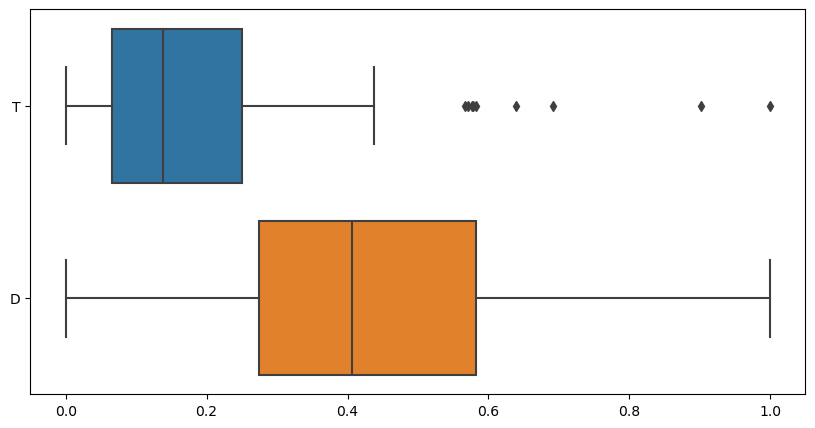

In [67]:
sns_temp = pd.DataFrame({'T':t_ind, 'D':d_ind})
fig, ax_sns = plt.subplots(figsize=(10, 5))
sns.boxplot(ax=ax_sns, data=sns_temp, orient='h')

<Axes: xlabel='tod_index', ylabel='issue_count_normalized'>

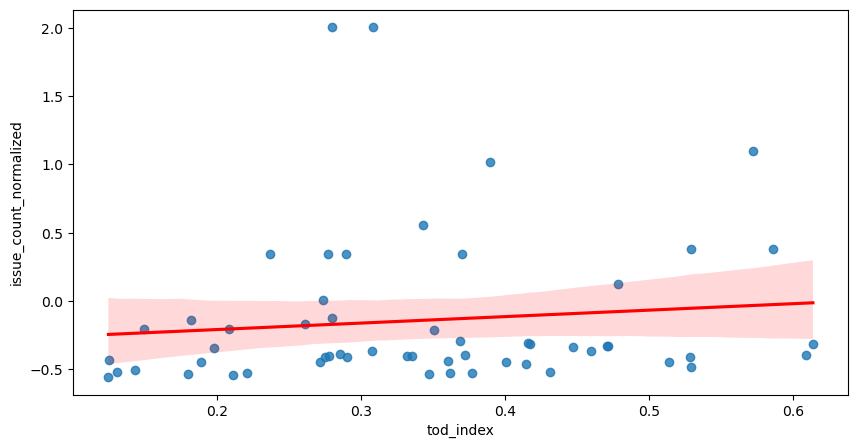

In [70]:
fig, ax_sns = plt.subplots(figsize=(10, 5))
sns.regplot(ax = ax_sns, x = h_rail_tracts2['tod_index'], y = h_rail_tracts2['issue_count'].rename('issue_count_normalized'), ci=95, line_kws={"color": "red"})

In [72]:
import scipy
temp_whatever = h_rail_tracts2[['tod_index', 'issue_count']]
temp_whatever = temp_whatever.dropna()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temp_whatever['tod_index'], temp_whatever['issue_count'])

print(slope)
print(intercept)
print(r_value)
print(p_value)
print(std_err)

0.47329818873087387
-0.30388923954279434
0.10907945710542512
0.4235617218173252
0.5869428437427037


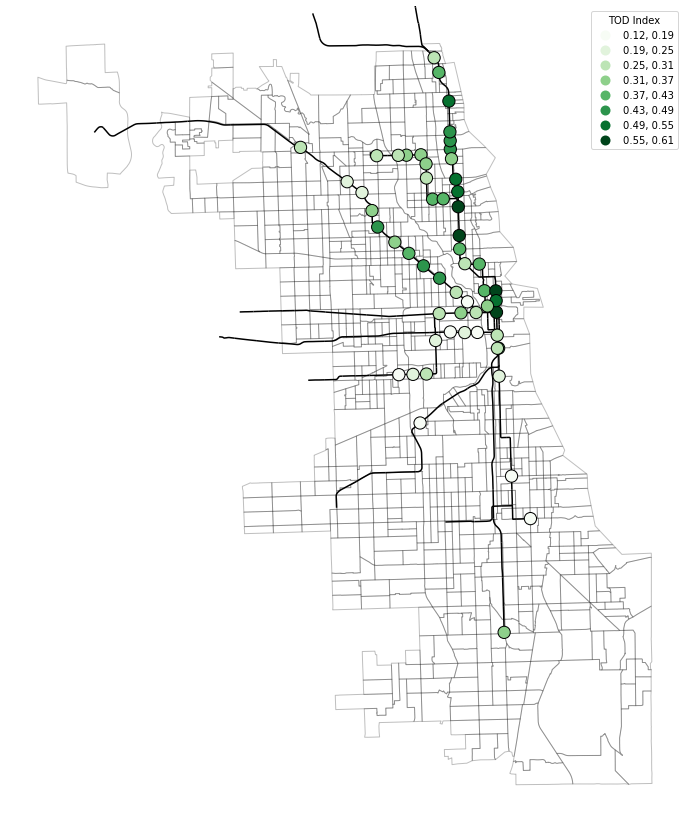

In [364]:
axis = tracts2.plot(edgecolor="#00000040", facecolor="none", figsize=(15, 15))
plt.autoscale(False)
h_rail_lines.plot(ax=axis, color='black', zorder=-1)
h_rail_tracts2.plot('tod_index', scheme='equal_interval', k=8,  cmap = 'Greens', ax=axis, legend=True, markersize=150, edgecolor="#000000", legend_kwds={'bbox_to_anchor':(1, 1), 'title':'TOD Index'}, zorder=1)
axis.set_axis_off()
plt.show()

In [286]:
# calc hypothetical scores for remaining stations
res_ind_hypo = []
for i in range(len(t_ind)):
    res_ind_hypo.append(t_ind[i]*0.5 + d_ind[i]*0.5)

h_rail_tracts2['tod_index_hypo'] = res_ind_hypo

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [360]:
h_rail_tracts2.sort_values("tod_index").reset_index(drop=True).head(10)

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
0,470,Racine,1.167775e+06,1.898083e+06,1706.000000,-0.36692,4.0,-0.557048,-0.416676,-1.141746,POINT (1167774.556 1898083.158),-0.641613,0.124683,0.124683
1,440,California-Douglas,1.158201e+06,1.890136e+06,1181.632877,-0.36692,1.0,-0.431474,-0.150371,-1.272975,POINT (1158201.074 1890136.339),-0.812750,0.125432,0.125432
2,130,51st,1.179152e+06,1.871283e+06,789.334247,-0.36692,1.0,-0.520341,-0.648490,-0.419987,POINT (1179151.842 1871283.076),-0.940785,0.130326,0.130326
3,120,35th/Archer,1.162148e+06,1.881158e+06,2455.594521,-0.36692,1.0,-0.504886,-0.769741,-0.895692,POINT (1162147.779 1881157.787),-0.396969,0.143009,0.143009
4,430,Clinton-Congress,1.172806e+06,1.897997e+06,2686.246575,-0.36692,1.0,-0.207373,-0.887290,-1.084334,POINT (1172806.092 1897996.847),-0.321691,0.149149,0.149149
5,720,Cottage Grove,1.182667e+06,1.863374e+06,829.778082,-0.36692,2.0,-0.535797,-0.112702,-0.141125,POINT (1182666.518 1863374.477),-0.927585,0.180279,0.180279
6,490,Grand/Milwaukee,1.170965e+06,1.903685e+06,2371.830137,-0.36692,2.0,-0.139757,-1.034321,-0.313363,POINT (1170964.659 1903685.420),-0.424307,0.182271,0.182271
7,740,Western-Douglas,1.160828e+06,1.890199e+06,908.093151,-0.36692,2.0,-0.446929,-0.021894,-0.214942,POINT (1160828.021 1890198.733),-0.902025,0.189006,0.189006
8,1030,Polk,1.165039e+06,1.896487e+06,2381.345205,-0.36692,1.0,-0.344538,-1.041860,0.154140,POINT (1165039.424 1896486.589),-0.421202,0.198123,0.198123
9,350,UIC-Halsted,1.170448e+06,1.897970e+06,4737.093151,-0.36692,3.0,-0.207373,-0.887290,-1.084334,POINT (1170448.200 1897969.675),0.347641,0.208448,0.208448


In [358]:
h_rail_tracts2.sort_values("tod_index", ascending=False).reset_index(drop=True).head(10)

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
0,1220,Fullerton,1.169427e+06,1.916013e+06,10190.531507,1.782185,3.0,-0.313628,0.546510,1.646869,POINT (1169427.095 1916013.325),2.127474,0.613946,0.613946
1,1320,Belmont-North Main,1.169245e+06,1.921369e+06,10260.726027,1.782185,6.0,-0.398632,0.588132,1.581255,POINT (1169244.560 1921368.701),2.150384,0.609323,0.609323
2,1450,Chicago/State,1.176231e+06,1.905726e+06,12333.838356,-0.366920,1.0,0.377993,1.548127,-1.510828,POINT (1176230.958 1905725.849),2.826983,0.586464,0.586464
3,260,State/Lake,1.176357e+06,1.901743e+06,10364.895890,3.931289,1.0,1.100525,1.347972,-1.330388,POINT (1176356.594 1901743.429),2.184382,0.572558,0.572558
4,330,Grand/State,1.176288e+06,1.903902e+06,10356.249315,-0.366920,1.0,0.377993,1.548127,-1.510828,POINT (1176288.179 1903902.005),2.181560,0.529283,0.529283
5,760,Granville,1.167506e+06,1.941003e+06,3292.613699,-0.366920,2.0,-0.481703,3.234597,1.007128,POINT (1167506.039 1941002.514),-0.123792,0.529209,0.529209
6,1420,Addison-North Main,1.169156e+06,1.924166e+06,7116.084932,-0.366920,3.0,-0.412155,0.971295,1.376210,POINT (1169155.598 1924165.785),1.124070,0.528382,0.528382
7,80,Sheridan,1.168783e+06,1.926476e+06,4120.175342,-0.366920,4.0,-0.443065,1.609611,1.950336,POINT (1168782.699 1926475.826),0.146299,0.513879,0.513879
8,590,Damen/Milwaukee,1.162783e+06,1.910383e+06,5542.876712,-0.366920,7.0,0.122982,0.571835,1.171164,POINT (1162783.214 1910383.122),0.610624,0.478659,0.478659
9,770,Lawrence,1.167769e+06,1.932067e+06,2672.317808,-0.366920,2.0,-0.331015,2.208081,1.228577,POINT (1167769.274 1932066.875),-0.326237,0.471329,0.471329


In [362]:
h_rail_tracts2.sort_values("tod_index_hypo").reset_index(drop=True).head(10)

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
0,750,Harlem-O'Hare,1.126839e+06,1.936585e+06,2314.728767,-0.36692,0.0,-0.518410,-0.820524,-2.191578,POINT (1126838.699 1936585.067),-0.442943,NaN,0.055908
1,1120,35-Bronzeville-IIT,1.177051e+06,1.882048e+06,1316.928767,-0.36692,0.0,-0.524205,-0.383655,-1.806093,POINT (1177050.915 1882047.587),-0.768594,NaN,0.076901
2,300,Indiana,1.178285e+06,1.878464e+06,635.515068,-0.36692,0.0,-0.518410,-0.485743,-1.207361,POINT (1178284.914 1878463.562),-0.990986,NaN,0.087868
3,290,Ashland/63rd,1.166854e+06,1.862752e+06,827.095890,-0.36692,0.0,-0.560911,-0.803667,-0.559418,POINT (1166854.408 1862752.122),-0.928460,NaN,0.110958
4,1040,Kedzie-Douglas,1.155312e+06,1.890061e+06,890.654795,-0.36692,0.0,-0.580230,-0.701201,-0.625032,POINT (1155312.299 1890060.722),-0.907717,NaN,0.113866
5,910,63rd-Dan Ryan,1.175808e+06,1.863400e+06,2569.123288,-0.36692,0.0,-0.549320,-1.170726,-0.961307,POINT (1175808.133 1863399.657),-0.359917,NaN,0.115097
6,1130,Halsted-Midway,1.170943e+06,1.887546e+06,2099.167123,-0.36692,0.0,-0.497159,-0.830806,-1.067930,POINT (1170942.966 1887545.796),-0.513296,NaN,0.118934
7,1140,King Drive,1.180025e+06,1.863287e+06,381.180822,-0.36692,0.0,-0.412155,-0.613558,-0.493803,POINT (1180024.551 1863287.025),-1.073993,NaN,0.122755
8,1330,Montrose-O'Hare,1.144639e+06,1.929108e+06,2102.983562,-0.36692,0.0,-0.466248,-0.583501,-1.281177,POINT (1144639.347 1929107.506),-0.512050,NaN,0.123010
9,780,Central Park,1.152738e+06,1.889992e+06,940.126027,-0.36692,0.0,-0.553184,-0.689083,-0.534812,POINT (1152737.529 1889991.516),-0.891571,NaN,0.123194


In [361]:
h_rail_tracts2.sort_values("tod_index_hypo", ascending=False).reset_index(drop=True).head(10)

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
0,380,Clark/Lake,1.175526e+06,1.901735e+06,15974.704110,5.005842,0.0,3.129022,-0.111140,-0.584023,POINT (1175525.859 1901735.366),4.015249,NaN,0.815110
1,1660,Lake/State,1.176365e+06,1.901404e+06,17673.531507,-0.366920,0.0,1.100525,1.347972,-1.330388,POINT (1176365.321 1901404.024),4.569693,NaN,0.783759
2,370,Washington/Dearborn,1.175927e+06,1.900801e+06,11443.693151,-0.366920,0.0,3.129022,-0.111140,-0.584023,POINT (1175927.284 1900801.153),2.536468,NaN,0.683942
3,1220,Fullerton,1.169427e+06,1.916013e+06,10190.531507,1.782185,3.0,-0.313628,0.546510,1.646869,POINT (1169427.095 1916013.325),2.127474,0.613946,0.613946
4,1320,Belmont-North Main,1.169245e+06,1.921369e+06,10260.726027,1.782185,6.0,-0.398632,0.588132,1.581255,POINT (1169244.560 1921368.701),2.150384,0.609323,0.609323
5,1380,Bryn Mawr,1.167634e+06,1.937301e+06,3808.783562,-0.366920,0.0,-0.535797,2.901601,2.294813,POINT (1167633.603 1937300.913),0.044670,NaN,0.599107
6,1450,Chicago/State,1.176231e+06,1.905726e+06,12333.838356,-0.366920,1.0,0.377993,1.548127,-1.510828,POINT (1176230.958 1905725.849),2.826983,0.586464,0.586464
7,260,State/Lake,1.176357e+06,1.901743e+06,10364.895890,3.931289,1.0,1.100525,1.347972,-1.330388,POINT (1176356.594 1901743.429),2.184382,0.572558,0.572558
8,880,Thorndale,1.167550e+06,1.939762e+06,2548.115068,-0.366920,0.0,-0.493295,4.273560,0.720065,POINT (1167550.174 1939762.068),-0.366773,NaN,0.552872
9,630,Clark/Division,1.175328e+06,1.908360e+06,6720.495890,-0.366920,0.0,-0.508750,2.580978,0.195149,POINT (1175328.346 1908360.200),0.994963,NaN,0.537211


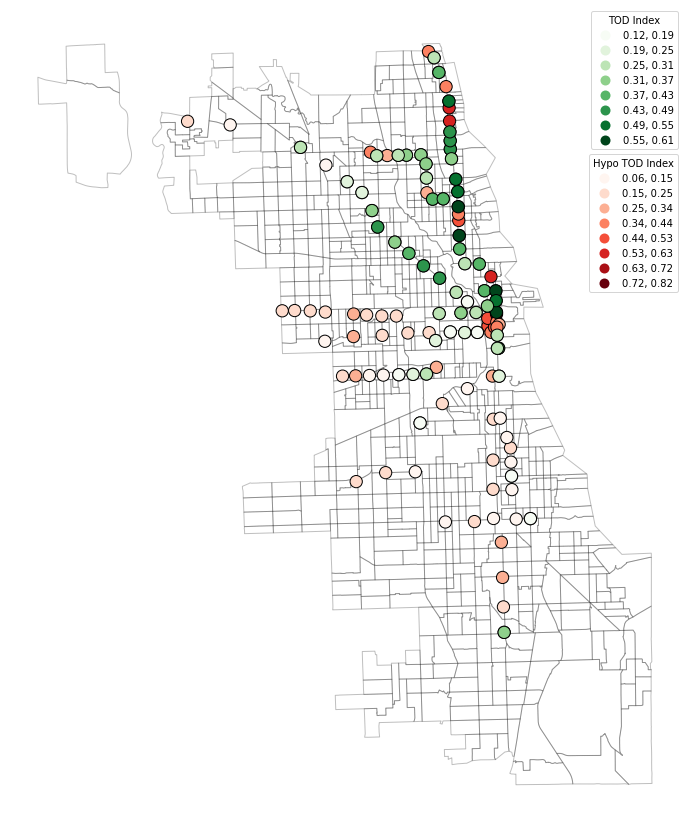

In [340]:
axis = tracts2.plot(edgecolor="#00000040", facecolor="none", figsize=(15, 15))
plt.autoscale(False)
h_rail_tracts2.plot('tod_index', scheme='equal_interval', k=8, cmap = 'Greens', ax=axis, legend=True, markersize=150, edgecolor="#000000", zorder=2, legend_kwds={'bbox_to_anchor':(1, 1), 'title':'TOD Index'})
leg1 = [c for c in axis.get_children() if isinstance(c, matplotlib.legend.Legend)]
h_rail_tracts2.plot('tod_index_hypo', scheme='equal_interval', k=8, cmap='Reds', ax=axis, legend=True, markersize=150, edgecolor="#000000", zorder=1, legend_kwds={'bbox_to_anchor':(1, 0.825), 'title':'Hypo TOD Index'})
axis.add_artist(leg1[0])
axis.set_axis_off()
plt.show()

In [306]:
# upper extreme
h_rail_tracts2.loc[h_rail_tracts2['STATION_ID'] == 1220]

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
50,1220,Fullerton,1.169427e+06,1.916013e+06,10190.531507,1.782185,3.0,-0.313628,0.54651,1.646869,POINT (1169427.095 1916013.325),2.127474,0.613946,0.613946


In [294]:
# right extreme
h_rail_tracts2.loc[h_rail_tracts2['STATION_ID'] == 720]

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
28,720,Cottage Grove,1.182667e+06,1.863374e+06,829.778082,-0.36692,2.0,-0.535797,-0.112702,-0.141125,POINT (1182666.518 1863374.477),-0.927585,0.180279,0.180279


In [295]:
# left extreme
h_rail_tracts2.loc[h_rail_tracts2['STATION_ID'] == 170]

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
3,170,Ashland-Lake,1.165707e+06,1.901502e+06,2041.273973,0.707632,3.0,2.004655,-0.741391,-0.994114,POINT (1165706.564 1901501.957),-0.53219,0.27997,0.27997


In [296]:
# lower extreme
h_rail_tracts2.loc[h_rail_tracts2['STATION_ID'] == 1690]

,STATION_ID,LONGNAME,POINT_X,POINT_Y,DAILY_AVG_19,NUM_LINES,tod_count,issue_count,Pop per Square Mile,Percent Transit to Work,geometry,DAILY_RIDER_DELTA,tod_index,tod_index_hypo
87,1690,Cermak-McCormick Place,1.176845e+06,1.889858e+06,1547.189041,-0.36692,3.0,0.343219,-0.048045,-0.493803,POINT (1176844.653 1889858.017),-0.693444,0.237098,0.237098


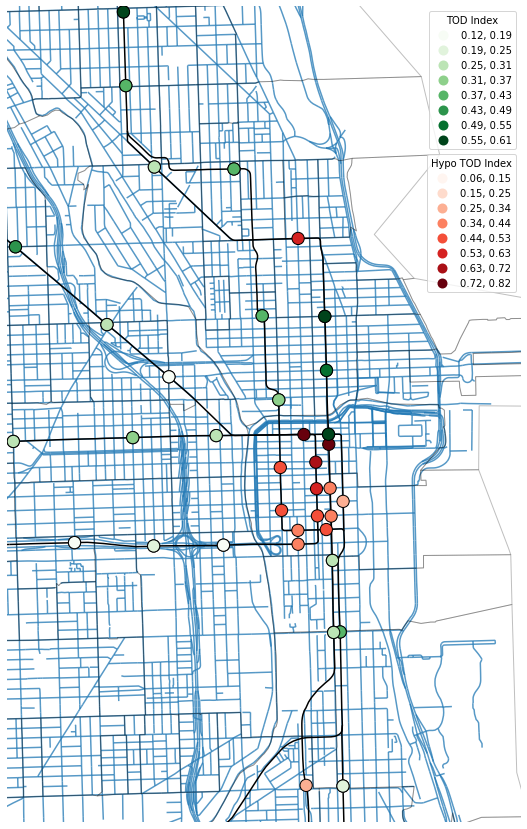

In [344]:
import matplotlib

axis = tracts2.plot(edgecolor="#00000040", facecolor="none", figsize=(15, 15))
plt.autoscale(False)
h_rail_lines.plot(ax=axis, color='black', zorder=-1)
h_rail_tracts2.plot('tod_index', scheme='equal_interval', k=8, cmap = 'Greens', ax=axis, legend=True, markersize=150, edgecolor="#000000", zorder=2, legend_kwds={'bbox_to_anchor':(1, 1), 'title':'TOD Index'})
leg1 = [c for c in axis.get_children() if isinstance(c, matplotlib.legend.Legend)]
h_rail_tracts2.plot('tod_index_hypo', scheme='equal_interval', k=8, cmap='Reds', ax=axis, legend=True, markersize=150, edgecolor="#000000", zorder=1, legend_kwds={'bbox_to_anchor':(1, 0.825), 'title':'Hypo TOD Index'})
streets.plot(ax=axis, zorder=-2, alpha=0.75)
axis.add_artist(leg1[0])
axis.set_axis_off()
plt.xlim(1165500.0, 1182850.0)
plt.ylim(1888650.0, 1916200.0)
plt.show()

# Maps and stuff

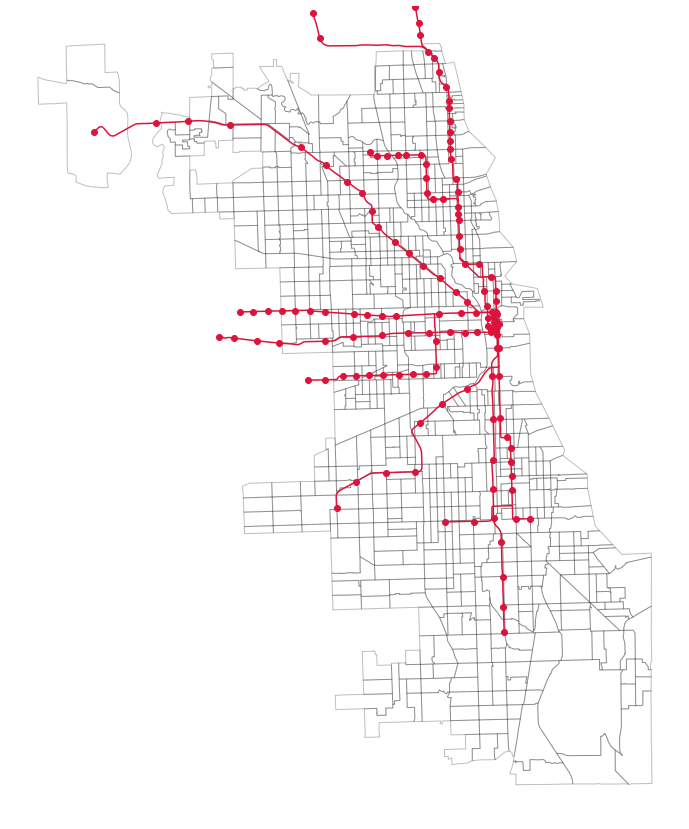

In [347]:
axis = tracts2.plot(edgecolor="#00000040", facecolor="none", figsize=(15, 15))
plt.autoscale(False)
h_rail.plot(color='crimson', ax=axis)
h_rail_lines.plot(color='crimson', ax=axis)
# metra_stns.plot(color='royalblue', ax=axis)
# metra_lines.plot(color='royalblue', ax=axis)
axis.set_axis_off()
plt.show()

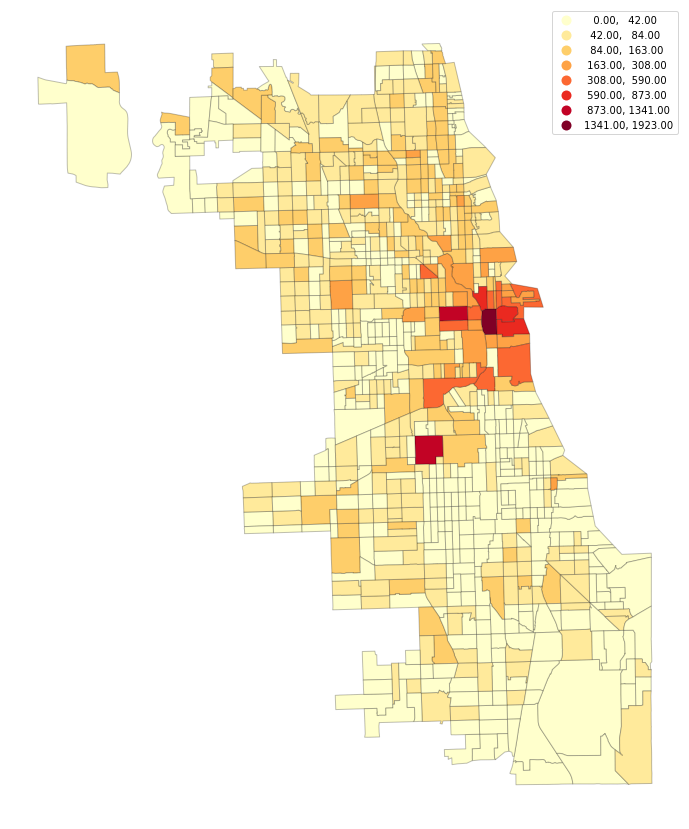

In [345]:
# DEFINE CUSTOM BINNING HERE
axis = tracts2.plot('issue_count', scheme='naturalbreaks', k=8, cmap='YlOrRd', edgecolor="#00000040", legend=True, figsize=(15, 15))
# tod_points.plot(marker='*', color='blue', ax=axis)
axis.set_axis_off()
plt.show()

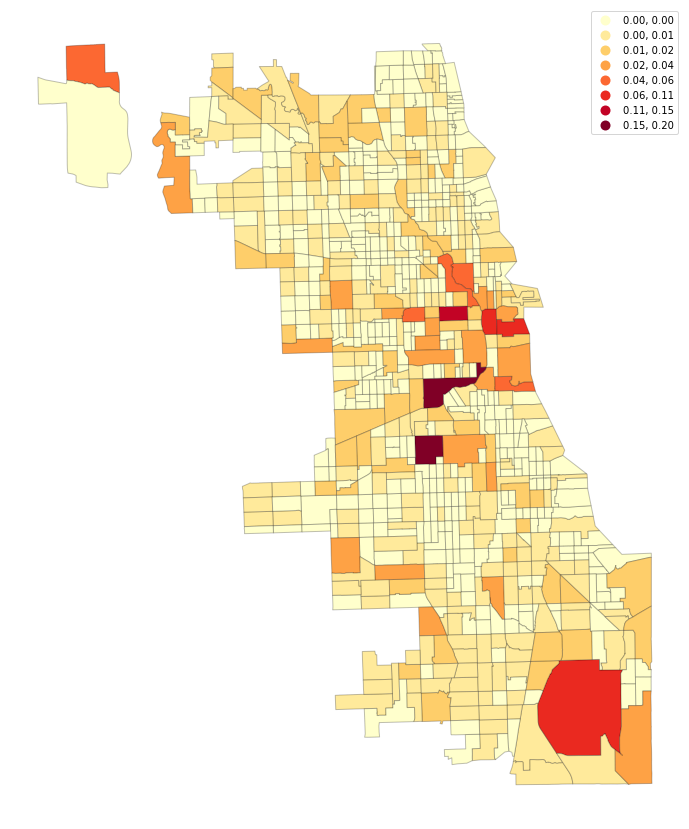

In [355]:
# tracts2_acs['issue_count_pop_adj'] = tracts2_acs['issue_count']/tracts2_acs['Pop per Square Mile']
axis = tracts2_acs.plot('issue_count_pop_adj', scheme='naturalbreaks', k=8, cmap='YlOrRd', edgecolor="#00000040", legend=True, figsize=(15, 15))
# tod_points.plot(marker='*', color='blue', ax=axis)
axis.set_axis_off()
plt.show()

In [351]:
tracts2_acs['issue_count_pop_adj'] = tracts2_acs['issue_count_pop_adj'].fillna(0)

In [354]:
tracts2_acs.replace([np.inf, -np.inf], 0, inplace=True)

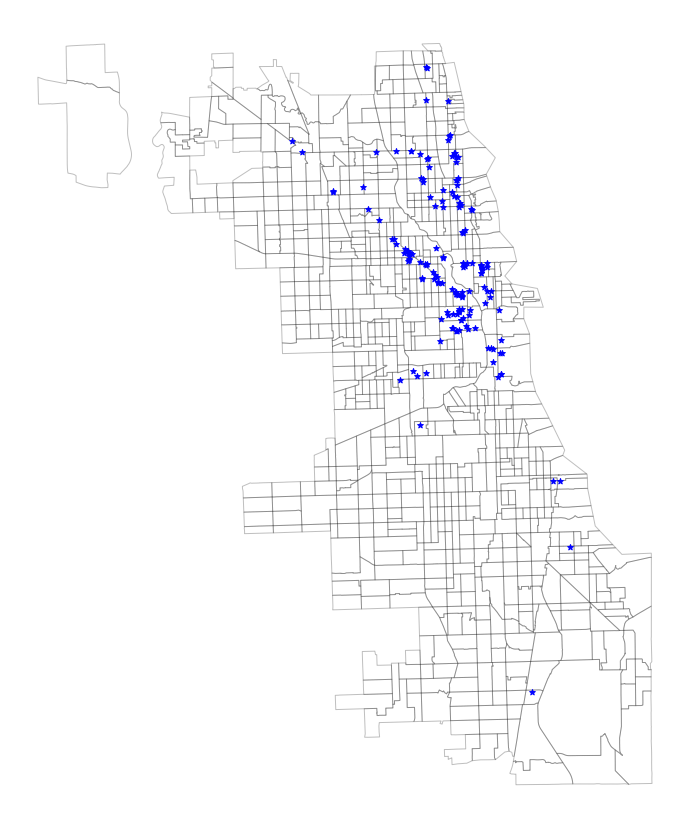

In [346]:
axis = tracts2.plot(facecolor="none", edgecolor="#00000040", legend=True, figsize=(15, 15))
tod_points.plot(marker='*', color='blue', ax=axis)
axis.set_axis_off()
plt.show()

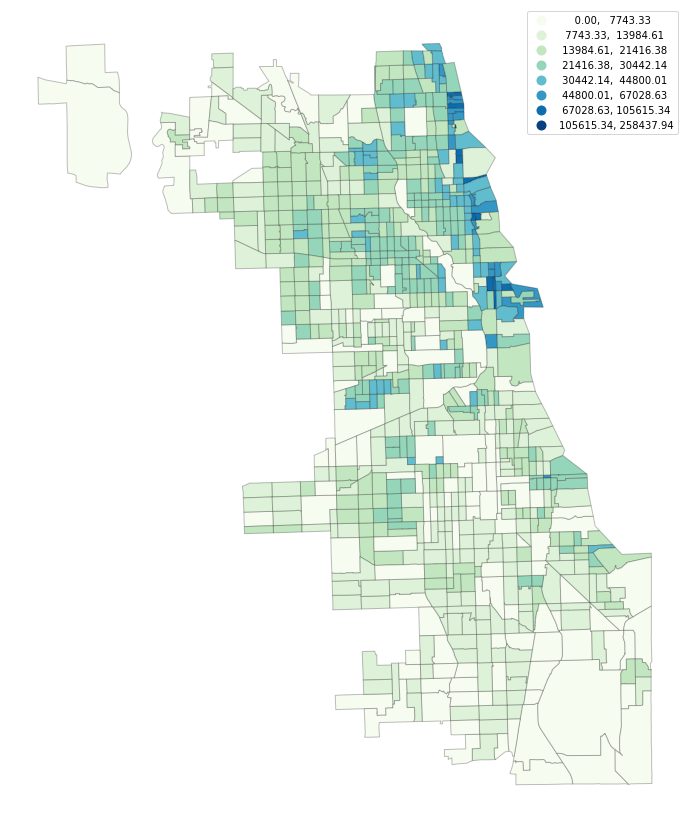

In [283]:
# DEFINE CUSTOM BINNING HERE
axis = tracts2_acs.plot('Pop per Square Mile', scheme='naturalbreaks', k=8, cmap='GnBu', edgecolor="#00000040", legend=True, figsize=(15, 15))
axis.set_axis_off()
plt.show()

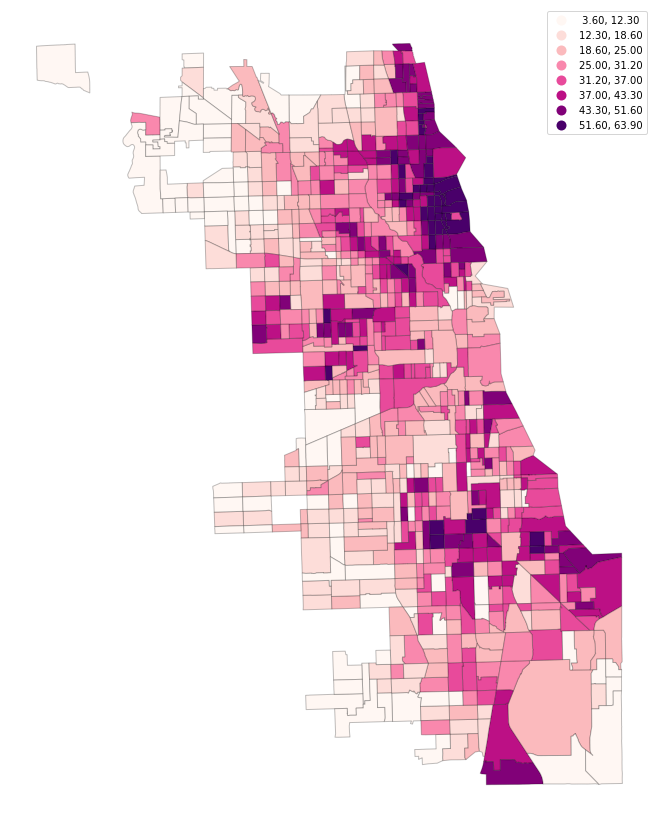

In [285]:
axis = tracts2_acs.plot('Percent Transit to Work', scheme='naturalbreaks', k=8, cmap='RdPu', edgecolor="#00000040", legend=True, figsize=(15, 15))
axis.set_axis_off()
plt.show()

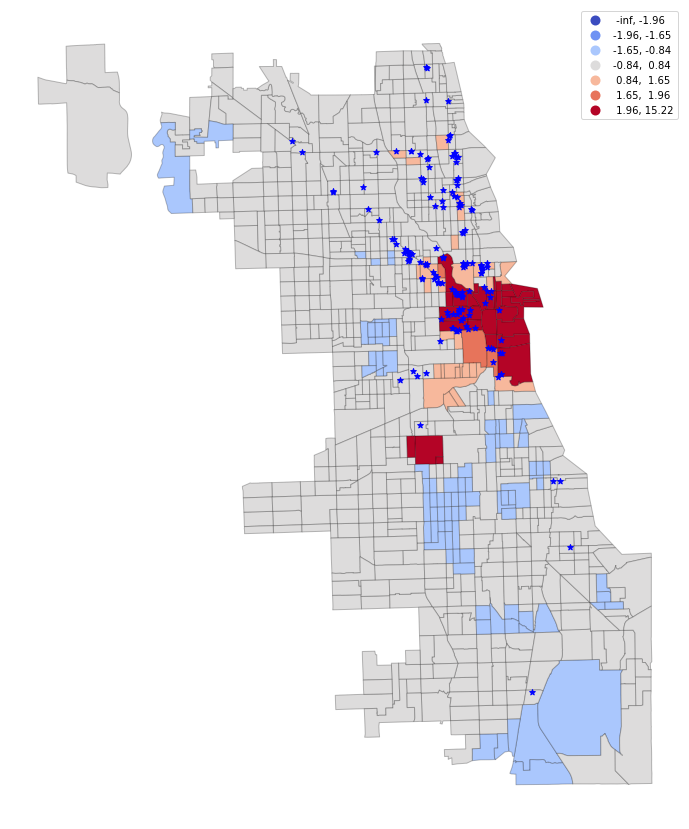

In [359]:
import esda.getisord

getisord = esda.getisord.G_Local(tracts2['issue_count'], tract_weights, star=True, transform="B")
tracts2_gi = tracts2
tracts2_gi["G"] = getisord.Zs
bins = [-1.96, -1.65, -0.84, 0.84, 1.65, 1.96]
axis = tracts2_gi.plot("G", cmap="coolwarm", legend=True, scheme="user_defined", classification_kwds={'bins':bins}, edgecolor = "#00000040", figsize=(15, 15))
tod_points.plot(marker='*', color='blue', ax=axis)
axis.set_axis_off()
plt.show()

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


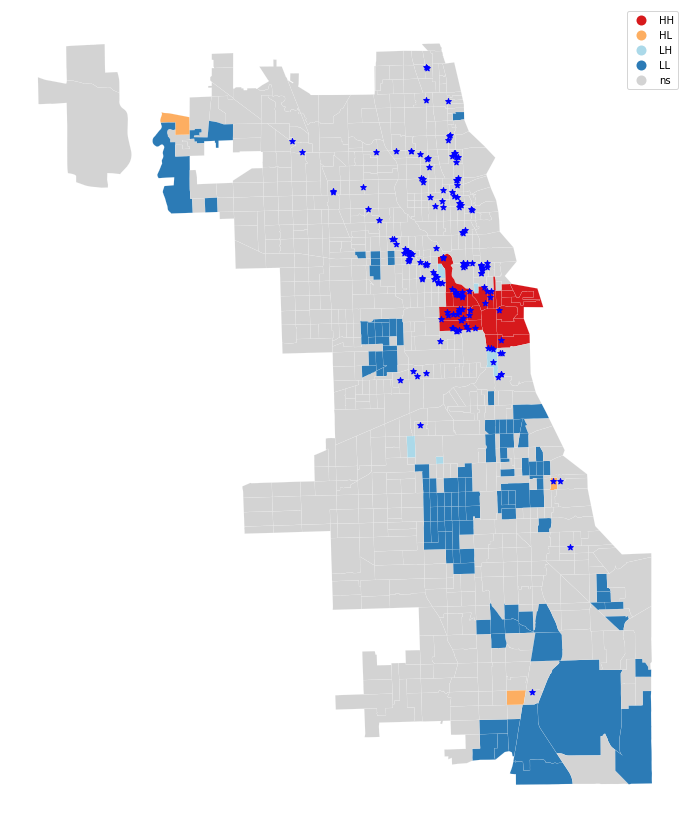

In [117]:
tracts2["ID"] = range(tracts2.shape[0])
tract_weights = pysal.lib.weights.KNN.from_dataframe(tracts2, ids="ID", k=4)
moran_local = esda.moran.Moran_Local(tracts2["issue_count"], tract_weights)
fig, axis = splot.esda.lisa_cluster(moran_local, tracts2[["issue_count", "geometry"]], figsize=(15, 15))
tod_points.plot(marker='*', color='blue', ax=axis)
plt.show()

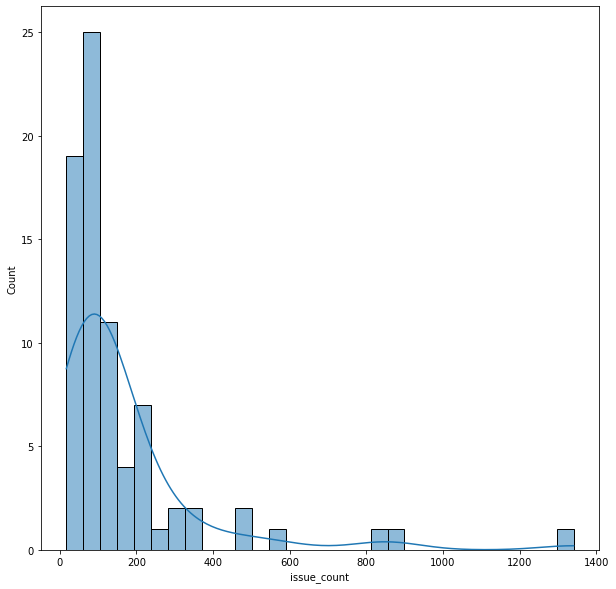

In [366]:
tracts2_has_tod = tracts2.loc[tracts2['has_tod'] > 0.0]
sns.histplot(tracts2_has_tod["issue_count"], kde=True)
plt.show()

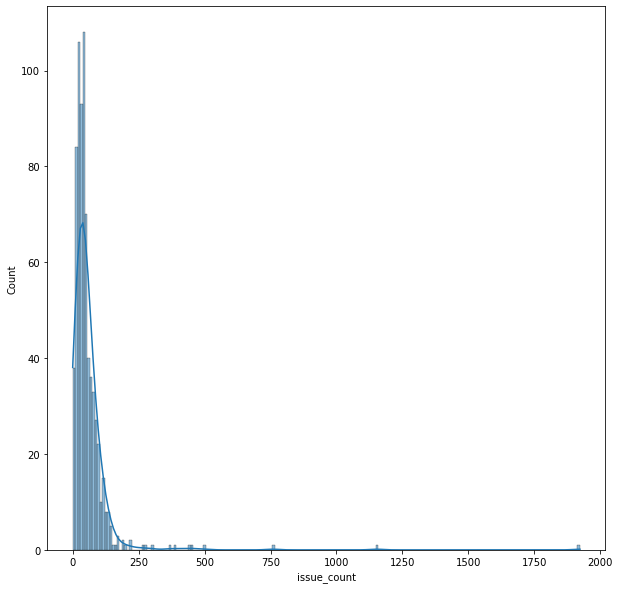

In [367]:
tracts2_no_tod = tracts2.loc[tracts2['has_tod'] == 0.0]
sns.histplot(tracts2_no_tod["issue_count"], kde=True)
plt.show()

# other

In [73]:
h_rail_lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LINES       153 non-null    object  
 1   DESCRIPTIO  153 non-null    object  
 2   TYPE        153 non-null    int64   
 3   LEGEND      153 non-null    object  
 4   SHAPE_LEN   153 non-null    float64 
 5   geometry    153 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 7.3+ KB


In [74]:
h_rail_lines.head()

,LINES,DESCRIPTIO,TYPE,LEGEND,SHAPE_LEN,geometry
0,"Brown, Orange, Pink, Purple (Express)",Tower 12 to Library,2,ML,647.793225,"LINESTRING (1176281.207 1898524.192, 1176455.9..."
1,"Brown, Purple",Subway Portal B to Sedgwick,2,BR,4303.794929,"LINESTRING (1173161.406 1910707.273, 1173040.5..."
2,Yellow Line,Oakton-Skokie to Howard,2,YL,21195.444430,"LINESTRING (1143503.410 1952679.758, 1143532.4..."
3,"Brown, Green, Orange, Pink, Purple (Exp)",Washington/Wabash to Adams/Wabash,2,ML,1352.120554,"LINESTRING (1176848.367 1899477.045, 1176824.9..."
4,"Brown, Green, Orange, Pink, Purple (Exp)",State/Lake to Washington/Wabash,2,ML,1317.604924,"LINESTRING (1176812.477 1900828.688, 1176787.6..."


In [92]:
metra_stns = gpd.read_file('./final_data/metra_stations/MetraStations.shp')
metra_stns = metra_stns.to_crs(h_rail.crs)

In [94]:
metra_stns.head()

,OBJECTID,STATION_ID,ASSET_ID,NAME,LONGNAME,LINES,BRANCH_ID,STATUS,MILEPOST,FAREZONE,...,TICKET_AVA,ADDRESS,MUNICIPALI,TELEPHONE,WEBLINK,LABELANGLE,EDIT_INIT,EDIT_DATE,YEAR_OPEN,geometry
0,1,1091.0,51201091.0,Stony Island,Stony Island,Electric,1,1,9.1,B,...,None,71st St. (at Stony Island Ave.),Chicago,None,None,30,ks,1995-08-02,None,MULTIPOINT (1187895.880 1858208.720)
1,2,1097.0,51201097.0,Bryn Mawr,Bryn Mawr,Electric,1,1,9.7,B,...,None,71st St. (at Jeffrey Blvd.),Chicago,None,None,30,ks,1995-08-02,None,MULTIPOINT (1190583.720 1858270.340)
2,3,1103.0,51201103.0,South Shore,South Shore,Electric,1,1,10.3,B,...,None,71st St. (near Yates and South Shore Dr.),Chicago,None,None,0,ks,1995-08-02,None,MULTIPOINT (1193664.510 1857979.740)
3,4,1109.0,51201109.0,Windsor Park,Windsor Park,Electric,1,1,10.9,B,...,None,75th St. (at Exchange Ave.),Chicago,None,None,0,ks,1995-08-02,None,MULTIPOINT (1195346.740 1855540.540)
4,5,1115.0,51201115.0,Cheltenham,Cheltenham (79th Street),Electric,1,1,11.5,B,...,None,79th St. (at Exchange Ave.),Chicago,None,None,0,ks,1995-08-02,None,MULTIPOINT (1197216.280 1853302.530)


In [97]:
metra_stns_chi = gpd.sjoin(metra_stns, tracts, how='inner')

In [132]:
metra_lines = gpd.read_file('./final_data/metra_lines/MetraLinesshp.shp')
metra_lines = metra_lines.to_crs(h_rail.crs)

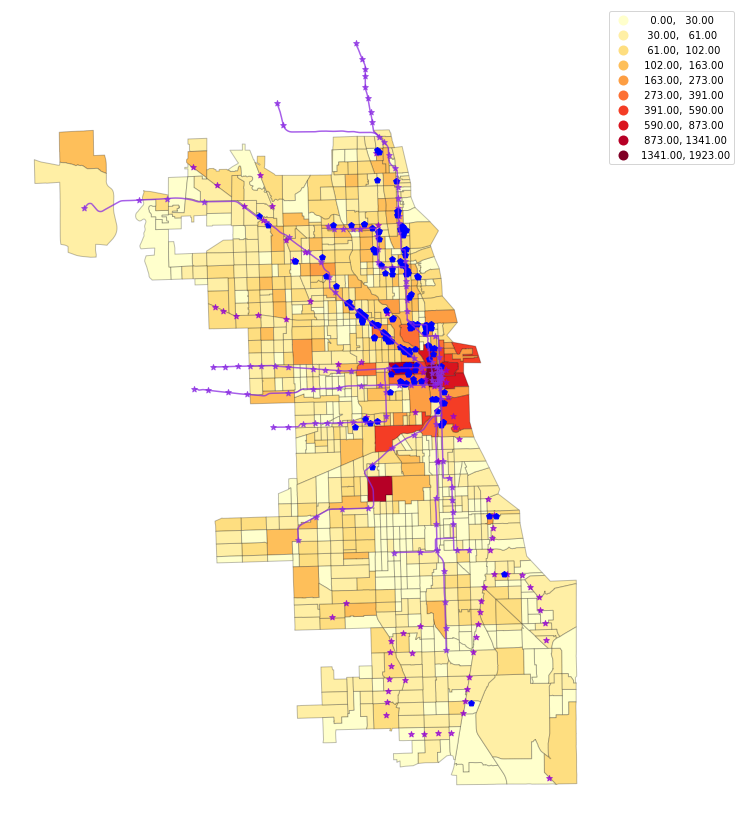

In [106]:
# DEFINE CUSTOM BINNING HERE
axis = tracts2.plot('issue_count', scheme='naturalbreaks', k=10, cmap='YlOrRd', edgecolor="#00000040", legend=True, legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1)), figsize=(15, 15))
h_rail.plot(marker='*', color='blueviolet', ax=axis, alpha=0.75)
h_rail_lines.plot(ax=axis, color='blueviolet', alpha=0.75)
metra_stns_chi.plot(marker='*', color='darkviolet', ax=axis, alpha=0.75)
tod_points.plot(marker='p', color='blue', ax=axis)
axis.set_axis_off()
plt.show()

In [3]:
zones = gpd.read_file("https://data.cityofchicago.org/api/geospatial/7cve-jgbp?method=export&format=GeoJSON")

In [24]:
zones = zones.to_crs(h_rail.crs)

In [77]:
all_streets = gpd.read_file('https://data.cityofchicago.org/api/geospatial/6imu-meau?method=export&format=GeoJSON')
all_streets = all_streets.to_crs(h_rail.crs)

<AxesSubplot:>

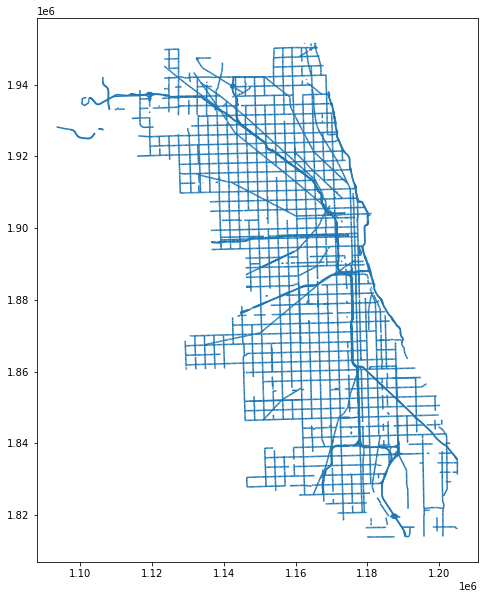

In [79]:
major_streets = gpd.read_file('./final_data/major_streets/Major_Streets.shp')
major_streets = major_streets.to_crs(h_rail.crs)
major_streets.plot()

<AxesSubplot:>

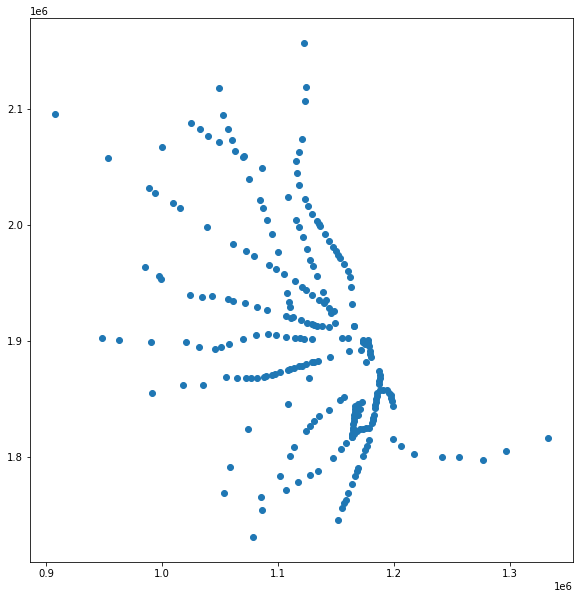

In [95]:
metra_stns.plot()

<AxesSubplot:>

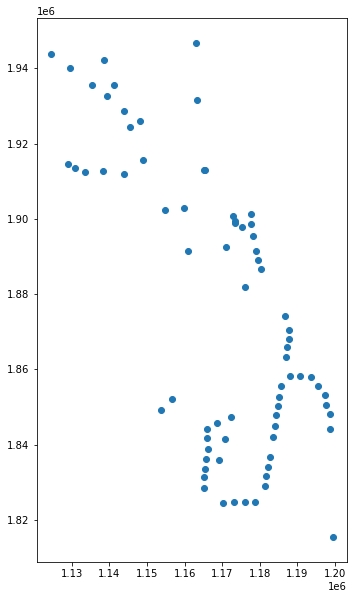

In [98]:
metra_stns_chi.plot()

In [343]:
streets = gpd.read_file('https://data.cityofchicago.org/api/geospatial/6imu-meau?method=export&format=GeoJSON')
streets = streets.to_crs(h_rail.crs)